In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import os
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array
import gradio as gr
from tensorflow.keras import backend as K

In [ ]:
# Constants
DEFAULT_IMAGE_SIZE = (64, 64)
N_IMAGES = 1000
ROOT_DIR = './Sign_Language_Dataset'
TRAIN_DIR = os.path.join(ROOT_DIR, 'asl_alphabet_train')
TEST_DIR = os.path.join(ROOT_DIR, 'asl_alphabet_test')
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [ ]:
# Function to process images
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE) # Grayscale conversion
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE) # Resize
            return img_to_array(image)
        return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
# Data Preparation
image_list, label_list = [], []
try:
    print("[INFO] Loading Images...")
    gesture_folders = os.listdir(TRAIN_DIR)
    for folder in gesture_folders:
        print(f"[INFO] Processing {folder}...")
        folder_path = os.path.join(TRAIN_DIR, folder)
        images = os.listdir(folder_path)[:N_IMAGES]
        for img in images:
            img_path = os.path.join(folder_path, img)
            if img_path.endswith(('.jpg', '.JPG')):
                image_list.append(convert_image_to_array(img_path))
                label_list.append(folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading Images...
[INFO] Processing D...
[INFO] Processing J...
[INFO] Processing H...
[INFO] Processing space...
[INFO] Processing L...
[INFO] Processing I...
[INFO] Processing C...
[INFO] Processing Y...
[INFO] Processing O...
[INFO] Processing R...
[INFO] Processing P...
[INFO] Processing K...
[INFO] Processing T...
[INFO] Processing G...
[INFO] Processing E...
[INFO] Processing U...
[INFO] Processing V...
[INFO] Processing del...
[INFO] Processing nothing...
[INFO] Processing F...
[INFO] Processing W...
[INFO] Processing S...
[INFO] Processing X...
[INFO] Processing N...
[INFO] Processing Z...
[INFO] Processing B...
[INFO] Processing A...
[INFO] Processing M...
[INFO] Processing Q...
[INFO] Image loading completed


In [ ]:
# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Total number of images: 29000


In [ ]:
# Normalize and transform data
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print("Total number of classes: ", n_classes)

Total number of classes:  29


In [ ]:
# Data Augmentation
augment = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
# Split data
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)

[INFO] Splitting data to train and test...


In [ ]:
# Build model
model = Sequential([
    Conv2D(32, (3, 3), padding="same", input_shape=(DEFAULT_IMAGE_SIZE[0], DEFAULT_IMAGE_SIZE[1], 1)),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding="same"),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding="same"),
    Activation("relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512),
    Activation("relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(n_classes),
    Activation("softmax")
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,749,405 (6.67 MB)

 Trainable params: 1,747,933 (6.67 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Compile Model
opt = Adam(learning_rate=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Train Model
history = model.fit(
    augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


725/725 ━━━━━━━━━━━━━━━━━━━━ 231s 313ms/step - accuracy: 0.2363 - loss: 3.0642 - val_accuracy: 0.5248 - val_loss: 1.5182
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


725/725 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5248 - val_loss: 1.5182
Epoch 3/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 253s 317ms/step - accuracy: 0.5561 - loss: 1.4348 - val_accuracy: 0.7591 - val_loss: 0.6978
Epoch 4/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7591 - val_loss: 0.6978
Epoch 5/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 244s 308ms/step - accuracy: 0.6979 - loss: 0.9371 - val_accuracy: 0.1997 - val_loss: 10.9883
Epoch 6/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1997 - val_loss: 10.9883
Epoch 7/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 225s 310ms/step - accuracy: 0.7578 - loss: 0.7179 - val_accuracy: 0.9062 - val_loss: 0.2837
Epoch 8/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9062 - val_loss: 0.2837
Epoch 9/50
725/725 ━━━━━━━━━━━━━━━━━━━━ 225s 310ms/step - accu

In [ ]:
print("[INFO] Calculating model accuracy")

scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100} %")

[INFO] Calculating model accuracy
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9899 - loss: 0.0345
Test Accuracy: 98.86206984519958 %


In [ ]:
# Evaluation
print("[INFO] Evaluating model...")
predictions = model.predict(x_test, batch_size=BATCH_SIZE)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

[INFO] Evaluating model...
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step


In [ ]:
model.save('/content/drive/MyDrive/sign_language_model.h5')
# Save the label binarizer
with open('/content/drive/MyDrive/sign_lang_transform.pkl', 'wb') as f:
    pickle.dump(label_binarizer, f)

In [ ]:
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=label_binarizer.classes_)
print("\nClasssification Report : ")
print(report)


Classsification Report : 
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       184
           B       0.99      1.00      1.00       208
           C       1.00      1.00      1.00       201
           D       1.00      1.00      1.00       180
           E       1.00      1.00      1.00       223
           F       0.97      1.00      0.99       191
           G       0.96      1.00      0.98       201
           H       1.00      1.00      1.00       205
           I       0.97      0.98      0.98       198
           J       1.00      0.95      0.98       189
           K       0.98      0.98      0.98       199
           L       0.99      0.99      0.99       198
           M       0.95      0.99      0.97       193
           N       1.00      0.96      0.98       192
           O       1.00      1.00      1.00       207
           P       1.00      1.00      1.00       212
           Q       1.00      1.00      1.00       197


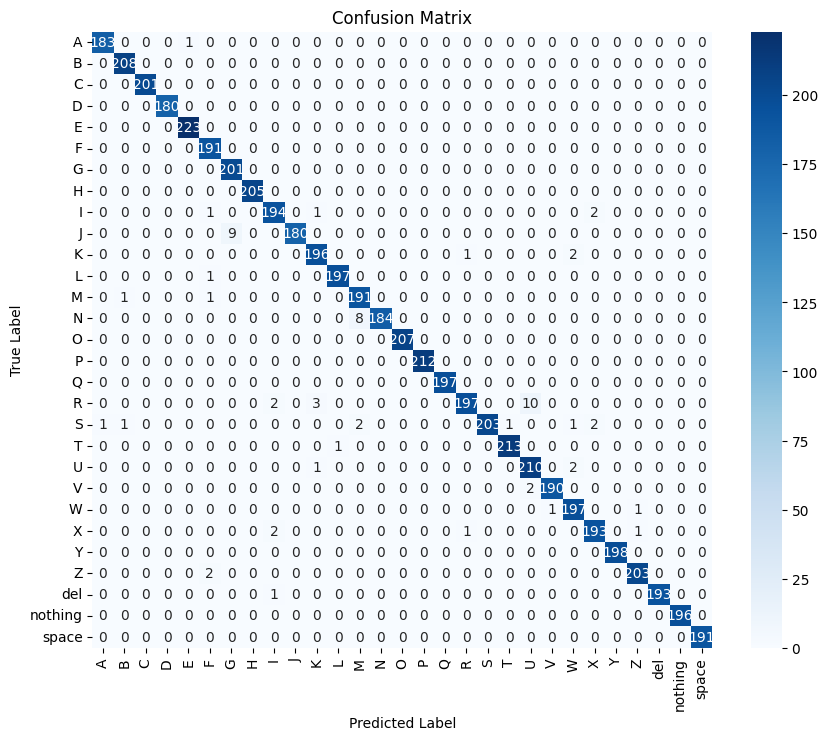

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

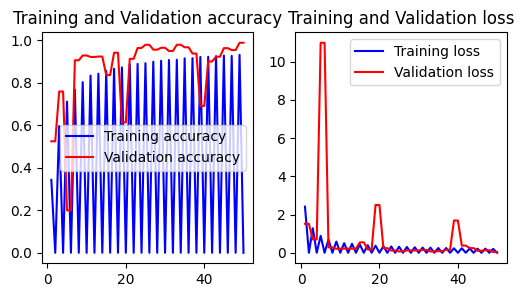

In [ ]:
# Training history visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
def predict_sign(image):
    try:
        # If image is a file path (string), process accordingly
        if isinstance(image, str):
            image_array = convert_image_to_array(image)
        else:
            # If the image is already an ndarray (from Gradio), process it
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
            image_array = cv2.resize(image, DEFAULT_IMAGE_SIZE)  # Resize
            image_array = img_to_array(image_array)  # Convert to array

        # Check if image processing was successful
        if image_array is not None:
            np_image = np.expand_dims(image_array / 255.0, axis=0)  # Normalize and expand dims
            prediction = model.predict(np_image)
            label = label_binarizer.classes_[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            return f"Predicted Sign: {label} (Confidence: {confidence:.2f}%)"

        return "Invalid Image"

    except Exception as e:
        return f"Error: {e}"

# Launch Gradio interface
demo = gr.Interface(
    fn=predict_sign,
    inputs=gr.Image(),
    outputs="text",
    title="Sign Language Translator",
    description="Upload an image of a sign language gesture to translate"
)
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://658f2c1491b461da4c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
